<a href="https://colab.research.google.com/github/prinakk/ML_UTS2019_ASSIGNEMT2/blob/master/SAFEynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://github.com/prinakk/ML_UTS2019_ASSIGNEMT2

# Assignment 2: Insurance claim prediction

By

## Prina Kamakotti:13171780 
## Aditya Bamidipati Lakshmana Murthy:13133638

# Introduction
The data collected for our project is from Porto Seguro, a leading insurance company in Brazil. They have used machine learning to make insurance claim predictions, using the same data. The challenge presented here is to build a model that will predict the customer who is most likely to make a claim in the next year.

Imagine a risky driver with a bad driving history, makes a claim year after year. This is grounds for increasing his/her insurance price for the next year. The prediction model's accuracy makes sure that this increase in price is reflected only on the bad-driver. If the accuracy is low, drivers with relatively fewer claims or less bad driving history might have their insurance price increased. This inaccuracy is the major concerning problem we are trying to deal with in this project.

The use of predictions with better accuracy will help both the customers, as well as the insurance company. Due to the drawback of more expenses for safe drivers and lower costs for risky ones, in effect, the prices are also highly reflected on the insurance company's profit.

With accurate predictions, they're used to fine-tune the prices for new and existing customers, helping to give more accessible coverage to drivers and with fair prices to every customer. This would lead to better profits for the company as a whole.

Due to the need for protecting the customer's information, the data has unlabelled features, which is a challenge on its own. There are around 595k records with each record having approximately 57 features. We use random forest and xg-boost classifiers with k-fold partitioning for model prediction.

# Initialisation

In [0]:

import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from IPython.display import Image
import configparser
import gc # clear RAM
import subprocess
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold
from sklearn.model_selection import KFold, train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
from sklearn.metrics import roc_curve, roc_auc_score, auc, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
import warnings
import pprint
import time
import os
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
import xgboost as xgb
from xgboost import XGBRegressor
from xgboost import XGBClassifier






In [57]:
os.getcwd()

'/content'

In [58]:
print(os.listdir('/content'))

['.config', 'kaggle_submission.csv', 'test.csv', 'train.csv', 'sample_data']


In [59]:
%%time


train = pd.read_csv('/content/train.csv', 
                    na_values=-1,
                    sep=',',
                    encoding='utf-8')
test = pd.read_csv('/content/test.csv', 
                   na_values=-1,
                   sep=',',
                   encoding='utf-8')

CPU times: user 8.7 s, sys: 265 ms, total: 8.96 s
Wall time: 8.97 s


In [0]:

id_test = test['id'].values

# Data Exploration
The data in question is from Kaggle, upoloaded by Porto Seguro. The data has 595,213 row data values. Each value has 57 features which are undefined and a 0/1 target column value which decides whether a claim is made or not. It can be seen that, 21,694 values have target association as 1 and the remaining as 0.   
The test data has 892,816 rows and has one less feature than the training data, which is 56. The excluded feature is the target, which needs to be found. 
We have four data types represented in the dataset. They are:

1.   Nominal which has 15 attributes
2.   Ordinal with 15 attributes
3.   Binary has 18 attributes and 
4.   Interval with 11.




We cannot rely on description to feature select and also due to the features being unlabeled, we cannot fit them as needed. These are problems we have identified. 

In [61]:
print(train.shape)
print(test.shape)

(595212, 59)
(892816, 58)


In [0]:
train.head()

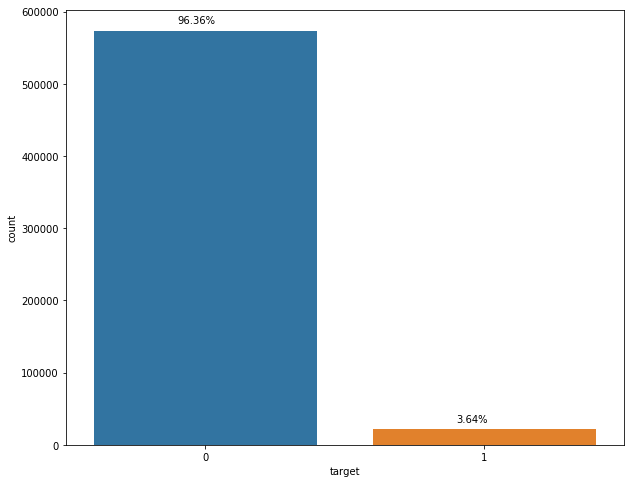

In [63]:
plt.figure(figsize=(10,8))


ax = sns.countplot('target', data=train)
for p in ax.patches:
    ax.annotate('{:.2f}%'.format(100*p.get_height()/len(train['target'])), 
                (p.get_x() + 0.3, p.get_height() + 10000))

In [64]:
train['target'].value_counts()


0    573518
1     21694
Name: target, dtype: int64

# Data Visualisation

Metadata: To ensure that data management is sufficient, we have stored the meta information of the attributes in a dataframe. This is helpful during visualising specific attributes for analysis and modelling. The attributes will be stored under: role, keep, level and dtype.

After storing the metadata information, we have correlated the training set between level and keep of the metadata. This correlation has been visulaized using a heatmap. We then represent the features found with the maximum correlation on a scatterplot, from which their relationships can be strongly observed.



## MetaData

In [0]:
def get_meta(train):
    data = []
    for col in train.columns:
        
        if col == 'target':
            role = 'target'
        elif col == 'id':
            role = 'id'
        else:
            role = 'input'

        
        if 'bin' in col or col == 'target':
            level = 'binary'
        elif 'cat' in col or col == 'id':
            level = 'nominal'
        elif train[col].dtype == np.float64:
            level = 'interval'
        elif train[col].dtype == np.int64:
            level = 'ordinal'

        
        keep = True
        if col == 'id':
            keep = False

        
        dtype = train[col].dtype

       
        col_dict = {
            'varname': col,
            'role'   : role,
            'level'  : level,
            'keep'   : keep,
            'dtype'  : dtype
        }
        data.append(col_dict)
    meta = pd.DataFrame(data, columns=['varname', 'role', 'level', 'keep', 'dtype'])
    meta.set_index('varname', inplace=True)
    return meta

## Meta Data

In [0]:
meta_data = get_meta(train)


In [0]:
meta_counts = meta_data\
                    .groupby(['role', 'level'])\
                        .agg({'dtype': lambda x: x.count()})\
                            .reset_index()
display(meta_counts)

,role,level,dtype
0,id,nominal,1
1,input,binary,17
2,input,interval,11
3,input,nominal,14
4,input,ordinal,15
5,target,binary,1


In [0]:
col_ordinal   = meta_data[(meta_data.level == 'ordinal') & (meta_data.keep)].index
col_nominal   = meta_data[(meta_data.level == 'nominal') & (meta_data.keep)].index
col_internval = meta_data[(meta_data.level == 'interval') & (meta_data.keep)].index
col_binary    = meta_data[(meta_data.level == 'binary') & (meta_data.keep) & (meta_data.role != 'target')].index

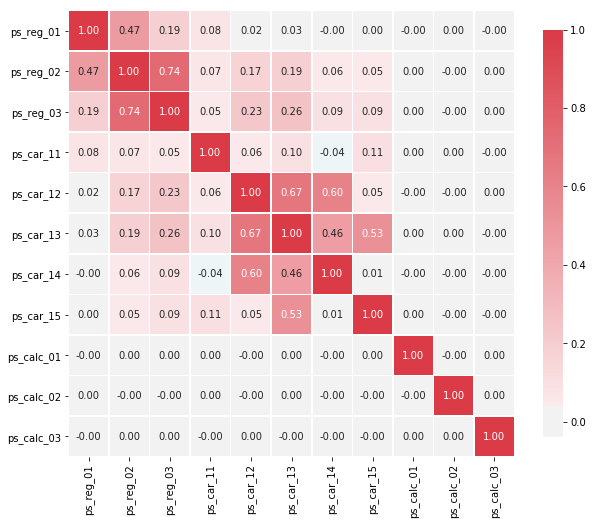

In [74]:
def corr_heatmap(v):
    correlations = train[v].corr()

    
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(correlations, cmap=cmap, vmax=1.0, center=0, fmt='.2f',
                square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .75})
    plt.show();
    
v = meta[(meta.mlevel == 'interval') & (meta.mkeeps)].index
corr_heatmap(v)

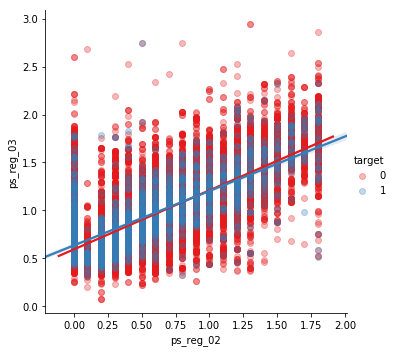

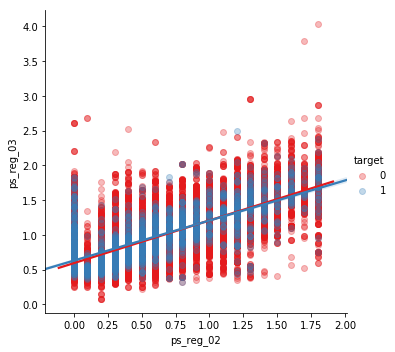

In [75]:
s = train.sample(frac=0.1)
sns.lmplot(x='ps_reg_02', y='ps_reg_03', data=s, hue='target', palette='Set1', scatter_kws={'alpha':0.3})
plt.show()

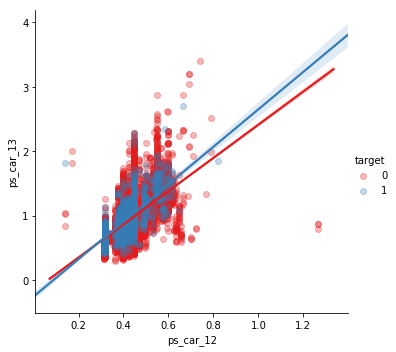

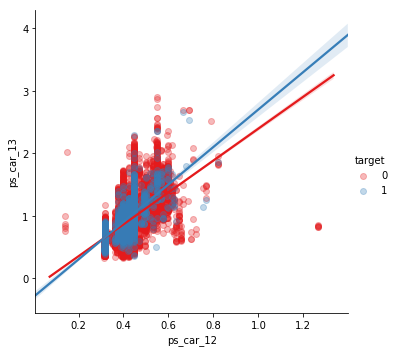

In [76]:
sns.lmplot(x='ps_car_12', y='ps_car_13', data=s, hue='target', palette='Set1', scatter_kws={'alpha':0.3})
plt.show()

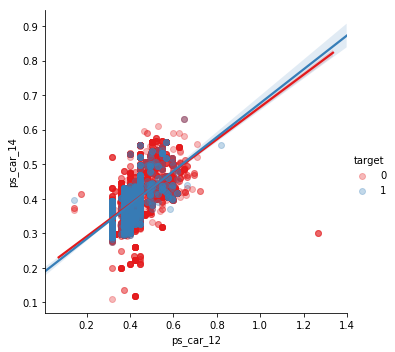

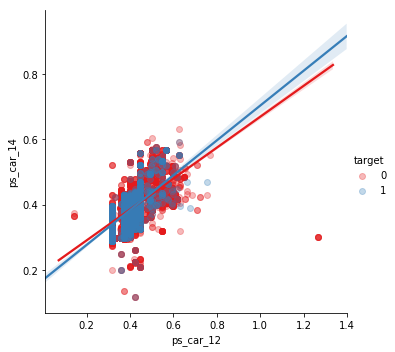

In [77]:
sns.lmplot(x='ps_car_12', y='ps_car_14', data=s, hue='target', palette='Set1', scatter_kws={'alpha':0.3})
plt.show()

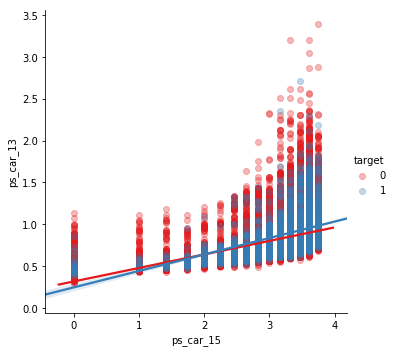

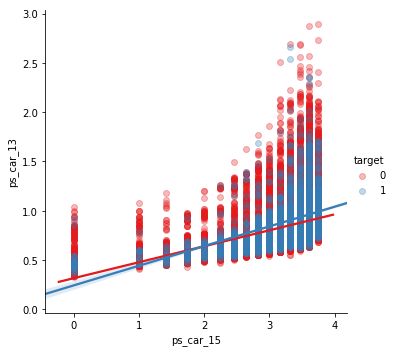

In [78]:
sns.lmplot(x='ps_car_15', y='ps_car_13', data=s, hue='target', palette='Set1', scatter_kws={'alpha':0.3})
plt.show()

# Data Pre-Processing

In the dataset, we observe that there are a few missing values. These values are represented by -1, which the model determines to be a value instead of null. Hence, we use 'NaN' to represent the missing values. This improvisation made the model slightly more efficent than with the default values.







## Missing Values



First, we displayed all the features which had a missing value. These features were correlated using a heatmap and dendogram, where the depth of the dendogram indicated the correlation between the features.

Next, through this viz, we came to a conclusion that the features ps_car_01_cat and ps_ind_04_cat are highly correlated, since their correlation is observed to be 1, they are colinear.

Because of this correlation, we have concluded that they might be the same attributes. Even if the missing values are replaced by NaN, the features won't affect the model efficency.


In [79]:
train.isnull().any()

id                False
target            False
ps_ind_01         False
ps_ind_02_cat      True
ps_ind_03         False
ps_ind_04_cat      True
ps_ind_05_cat      True
ps_ind_06_bin     False
ps_ind_07_bin     False
ps_ind_08_bin     False
ps_ind_09_bin     False
ps_ind_10_bin     False
ps_ind_11_bin     False
ps_ind_12_bin     False
ps_ind_13_bin     False
ps_ind_14         False
ps_ind_15         False
ps_ind_16_bin     False
ps_ind_17_bin     False
ps_ind_18_bin     False
ps_reg_01         False
ps_reg_02         False
ps_reg_03          True
ps_car_01_cat      True
ps_car_02_cat      True
ps_car_03_cat      True
ps_car_04_cat     False
ps_car_05_cat      True
ps_car_06_cat     False
ps_car_07_cat      True
ps_car_08_cat     False
ps_car_09_cat      True
ps_car_10_cat     False
ps_car_11_cat     False
ps_car_11          True
ps_car_12          True
ps_car_13         False
ps_car_14          True
ps_car_15         False
ps_calc_01        False
ps_calc_02        False
ps_calc_03      

In [0]:
missingValueColumns = train.columns[train.isnull().any()].tolist()


df_null = train[missingValueColumns]

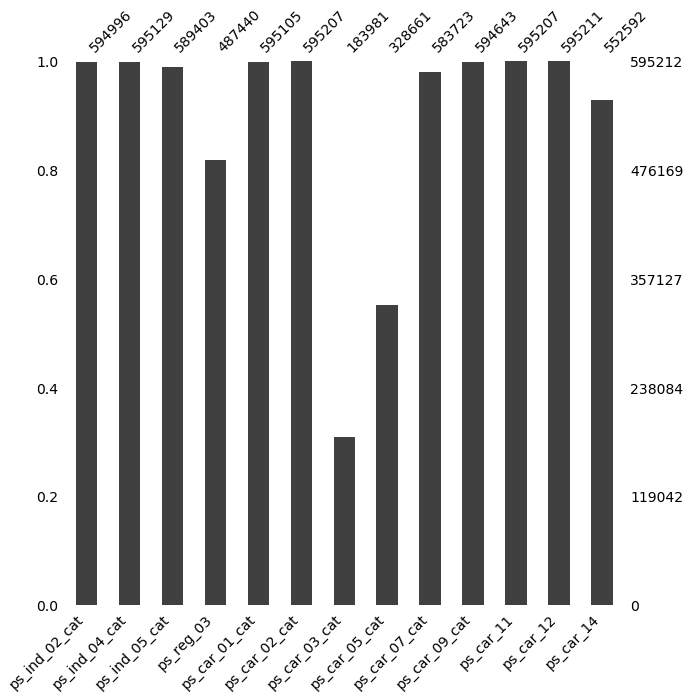

In [81]:
msno.bar(df_null,figsize=(10,10), fontsize=14, labels=True, color=(0.25, 0.25, 0.25))

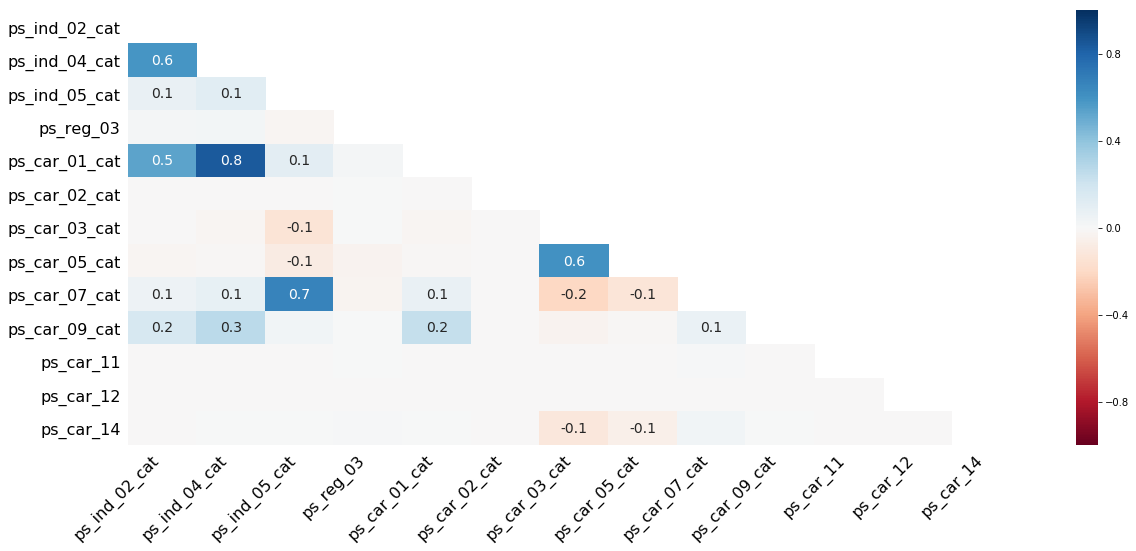

In [82]:
msno.heatmap(df_null,figsize=(20,8))

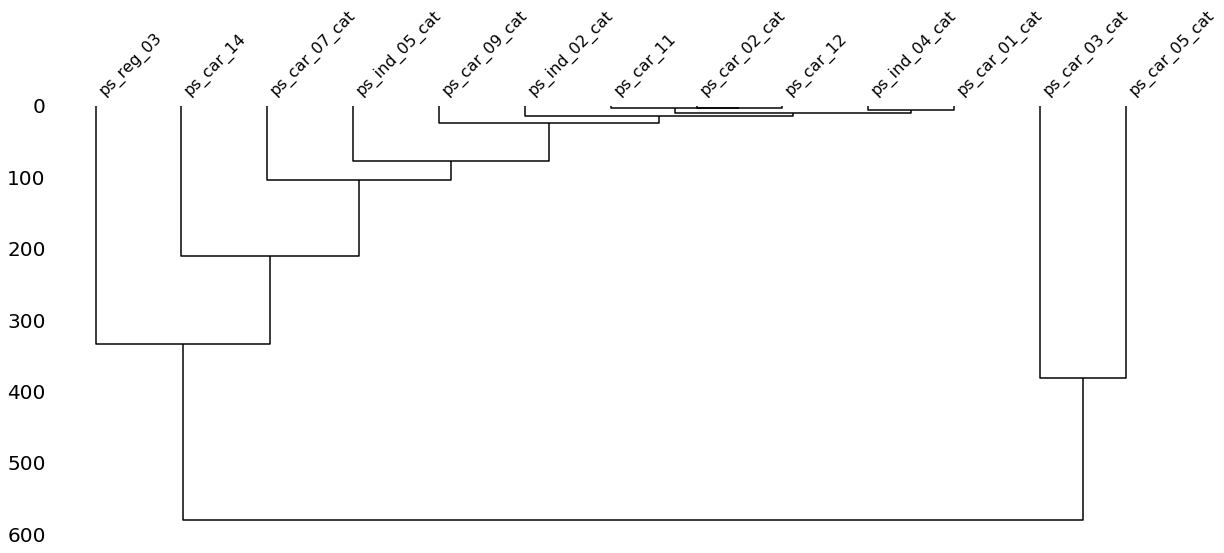

In [83]:
msno.dendrogram(df_null, figsize=(20,8))

In [0]:
sorted_data = msno.nullity_sort(df_null, sort='descending')


In [85]:
display(col_internval)

Index(['ps_reg_01', 'ps_reg_02', 'ps_reg_03', 'ps_car_11', 'ps_car_12',
       'ps_car_13', 'ps_car_14', 'ps_car_15', 'ps_calc_01', 'ps_calc_02',
       'ps_calc_03'],
      dtype='object', name='varname')

In [0]:
corr_matrix = train[col_internval].corr()


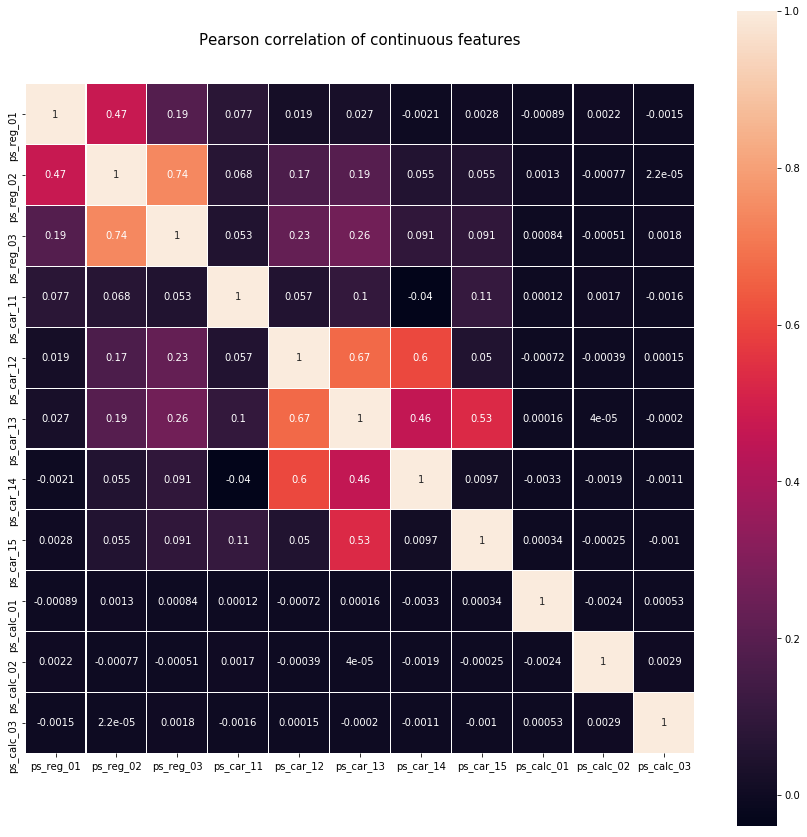

In [87]:
plt.figure(figsize=(15,15))
plt.title('Pearson correlation of continuous features', y=1.05, size=15)
sns.heatmap(train[col_internval].corr(),
            linewidths=0.1,
            vmax=1.0, 
            square=True, 
            linecolor='white', 
            annot=True)

In [0]:

train.fillna(-1, inplace=True)
test.fillna(-1, inplace=True)

## Sampling

Since, we have discovered that the class atrribute, target, is highly unbalanced, we have performed a SMOTE operation on the class attribute. What this does is, it oversamples the minority class to bring some balance to the class attribute.

In our dataset, we have observed the minority class to be:

1 which has 21694 values and total of 3.64% of the class attribute.
0 has 573518 values and total of 96.36% of the class attribute.
After SMOTE, we have oversampled the minority class '0' to a percentage of 10% and have observed that the efficency of the model drastically reduces. Since its unbalanced, we should not rely on accuracy of model but on the f-score and the like.

In [0]:
#from sklearn.utils import shuffle
#desired_apriori=0.10

# Get the indices per target value
#idx_0 = train[train.target == 0].index
#idx_1 = train[train.target == 1].index

# Get original number of records per target value
#nb_0 = len(train.loc[idx_0])
#nb_1 = len(train.loc[idx_1])

# Calculate the undersampling rate and resulting number of records with target=0
#undersampling_rate = ((1-desired_apriori)*nb_1)/(nb_0*desired_apriori)
#undersampled_nb_0 = int(undersampling_rate*nb_0)
#print('Rate to undersample records with target=0: {}'.format(undersampling_rate))
#print('Number of records with target=0 after undersampling: {}'.format(undersampled_nb_0))

# Randomly select records with target=0 to get at the desired a priori
#undersampled_idx = shuffle(idx_0, random_state=37, n_samples=undersampled_nb_0)

# Construct list with remaining indices
#idx_list = list(undersampled_idx) + list(idx_1)

# Return undersample data frame
#train = train.loc[idx_list].reset_index(drop=True)

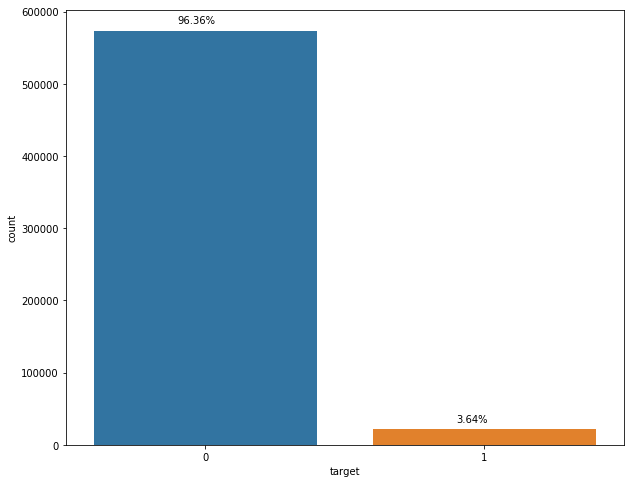

In [90]:
plt.figure(figsize=(10,8))


ax = sns.countplot('target', data=train)
for p in ax.patches:
    ax.annotate('{:.2f}%'.format(100*p.get_height()/len(train['target'])), 
                (p.get_x() + 0.3, p.get_height() + 10000))

In [91]:
train['target'].value_counts()


0    573518
1     21694
Name: target, dtype: int64

# Data Modelling And Analysis
## Feature Selection:

Since the machine learning model is based on the features, it is crucial to select the features that contribute most to the prediction. To relaize this, we have used a random forest model to classify the features according to their importance and have ranked the top ten based on the classification.

After this, we have removed the features which are found to have their importance less than 0.01

## Training the model with training dataset:

Split the training data. To achieve this, we have used the K-fold cross validation method. This split the training data into three folds. This method is a re-sampling procedure to evaluate and train the machine learning model.

## Model 1 and Model 2 comparative study:

### RandomForest: Defining the machine learning model:

We have used a randomforest classifier and we've trained this model using the cross validation method. Further, we have found in the three validations, that the model scored 0.62460 in the first, 0.59937 in the second fold and in the final one 0.539.

### Testing the model with test data:


The entire test data is then given to the trained model as input. The model then predicts the target attribute for the test data. The predicted out is finally evaluated with the actual results on Kaggle. Evaluation results: .

### XGB: Defining the model:

Using the XGB classifier, we've followed the same cross validation method to train the model. In the first fold we observed a score of 0.56328 , in the second the score was 0.58177 and the final score was 0.54258 .

### With test data:

The test data as a whole is again the input, the only change is the classifer. The model predicts the class attribute - target and this prediction is evaluated on Kaggle. The evaluation output is: .

The Kaggle output is attached in the GitHub Repo.

## Training sample split

In [0]:
def cross_val_model(X,y, model, n_splits=3):
    'Do split dataset and calculate cross_score'
    X = np.array(X)
    y = np.array(y)
    folds = list(StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=2017).split(X, y))

    for j, (train_idx, test_idx) in enumerate(folds):
        X_train = X[train_idx]
        y_train = y[train_idx]
        X_holdout = X[test_idx]
        y_holdout = y[test_idx]

        print ("Fit %s fold %d" % (str(model).split('(')[0], j+1))
        model.fit(X_train, y_train)
        cross_score = cross_val_score(model, X_holdout, y_holdout, cv=3, scoring='roc_auc')
        print("    cross_score: %.5f" % cross_score.mean())

## Feature Selection

In [0]:
def get_feature_importance_df(feature_importances,
                              column_names, 
                              top_n=10):
    """Get feature importance data frame.
 
    Parameters
    ----------
    feature_importances : numpy ndarray
        Feature importances computed by an ensemble 
            model like random forest or boosting
    column_names : array-like
        Names of the columns in the same order as feature 
            importances
    top_n : integer
        Number of top features
 
    Returns
    -------
    df : a Pandas data frame"""
     
    imp_dict = dict(zip(column_names, feature_importances))
    
   
    top_features = sorted(imp_dict, key=imp_dict.get, reverse=True)[0:top_n]
    
    
    top_importances = [imp_dict[feature] for feature in top_features]
    
    
    df = pd.DataFrame(data={'feature': top_features, 'importance': top_importances})
    return df

In [0]:
# create model
from sklearn.ensemble import RandomForestClassifier


rf = RandomForestClassifier(n_estimators=150,
                            max_depth=8,
                            min_samples_leaf=4,
                            max_features=0.2, 
                            n_jobs=-1,
                            random_state=42)

In [95]:
rf.fit(train.drop(['target'], axis=1), train.target)
features = train.drop(['target'], axis=1).columns.values
print("---Traing Done---")

---Traing Done---


In [96]:

feature_importance = get_feature_importance_df(rf.feature_importances_, features)


feature_importance

,feature,importance
0,ps_car_13,0.130138
1,ps_ind_05_cat,0.072278
2,ps_reg_03,0.068513
3,ps_ind_17_bin,0.056633
4,ps_ind_03,0.037766
5,ps_reg_02,0.036831
6,id,0.035909
7,ps_car_07_cat,0.031743
8,ps_car_04_cat,0.027767
9,ps_car_14,0.027429


In [0]:
def get_without_importance(df_feature_importance: 'dataframe') -> list:
    list_drop_col = []
              
    cond_duracao = (df_feature_importance['importance'] < 0.01)
    df_temp = df_feature_importance[cond_duracao]
    
    list_drop_col = df_temp['feature'].tolist()
    
    print("-"*25, "FEATURE WITHOUT IMPORTANCE", "-"*25, end='\n\n')
    print(df_temp)
    return list_drop_col

In [0]:
def remove_without_importace(df: 'dataframe', list_without_imp: list) -> int:
    print(f'Columns before = {df.shape[1]}')
    
    for column in list_without_imp:
        del df[column]
        
    return print(f"Columns after = {df.shape[1]}")

In [99]:
list_without_importance = get_without_importance(df_feature_importance = feature_importance)

------------------------- FEATURE WITHOUT IMPORTANCE -------------------------

Empty DataFrame
Columns: [feature, importance]
Index: []


## Random Forest Classifier

In [0]:

rf_params = {}
rf_params['n_estimators'] = 200
rf_params['max_depth'] = 6
rf_params['min_samples_split'] = 70
rf_params['min_samples_leaf'] = 30
rf_params['n_jobs'] = -1

In [101]:
RandomForestClassifier()

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators='warn',
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [0]:

rf_model = RandomForestClassifier(**rf_params)

# training model
X = train.drop('target',axis=1)
y = train['target']

In [103]:

cross_val_model(X, y, rf_model)

Fit RandomForestClassifier fold 1
    cross_score: 0.62460
Fit RandomForestClassifier fold 2
    cross_score: 0.59937
Fit RandomForestClassifier fold 3
    cross_score: 0.58394


## XGBoost Classifier

In [0]:
xgb_params = {}
xgb_params['learning_rate'] = 0.02
xgb_params['n_estimators'] = 100
xgb_params['max_depth'] = 6
xgb_params['subsample'] = 0.9
xgb_params['colsample_bytree'] = 0.9

In [0]:

XGB_model = XGBClassifier(**rf_params)


X = train.drop('target',axis=1)
y = train['target']

In [112]:
cross_val_model(X, y, XGB_model)

Fit XGBClassifier fold 1
    cross_score: 0.56328
Fit XGBClassifier fold 2
    cross_score: 0.58177
Fit XGBClassifier fold 3
    cross_score: 0.54258


In [0]:
def save_data_clenning(df: 'dataframe' = None,
                       path: str = 'data/cleansing/') -> None:
    df.to_csv(path_or_buf = path,
              sep = ',',
              index = False,
              encoding = 'utf8')
    
    return "Data storage!"

In [105]:
submission = pd.DataFrame(columns=['id', 'target'])
submission['id'] = id_test
submission['target'] = rf_model.predict_proba(test)[:, 1] 

save_data_clenning(df = submission,
                   path = '/content/kaggle_submission.csv')

'Data storage!'

#Conclusion

##Reflection and possible improvements

Throughout the entire project we have observed that any dataset cannot be taken for granted in its original state. There is involved a lot of pre-processing and data cleaning to bring it to a usable format. 

Secondly, we have seen that the data is prone to overfit the model which greatly decreases the performance. 

From exploring the data and visualizing it, we access important information about the characteristics of the data. This helps us understand how the data features interact with each other. This in-turn, gives us an idea about how it'll work with the model. 

During exploration we found that the class atrribute was unbalanced with respect to the number of '0/1s'. This leads to an incredibly high biased result on predictions. Using SMOTE somewhat increased the minority class, but since the majority class values were being replaced, the accuracy decreased further due to inaccurate data. We have realized that working with real data is not straightforward and that there is a lot of compromise needed to see results that are highly accurate representation of reality.

We have used ensemble models which were prone to overfit on the training data. This led us to believe that there could be a few improvements made to the whole process.

The parameters of our models could be tweaked and more params could be looked at for better modelling and outputs. Replacing missing values of features could be done with mean or mode for the training data. Sometimes predicting the missing values first using a model and then using those features might also improve the accuracy. Final word would be try more complex models.    

#Ethical Study

Since the dataset belongs to an Insurance firm and it deals with predicting insurance claims, the focus of this ethical study will be on the insurance industry.

We shall use the Kantian approach to perform this ethical study.

There are three factors in the Kantian approach for this industry:

## 1. Dealing with Universal Law

According to Kant, the moral actions of a human is based on valid reason and impartiality. In the instance of insurance claims, if the debtor refuses to pay, such an action is driven by personal inclination and gain. Hence, it would not be ethical. A person of good moral character would perform a right action from a maxim that is universalizable. This universal law is the key to an act to be moral.

## 2. Autonomy and dignity

Kant expressed through categorical imperative that using a person to achieve one's own goal is against the inherent dignity and indivuality of a person. In claims, an action such as faulting on payments represents a concept of breaking an agreement. Which is unethical. 

Much of the ethical issues in the insurance industry are a case of utilitarian gain. As companies are adapting and moving towards an ethical consicousness, there is still a lot of space for improvement and increased awareness in ethical practices. Hence, these should be prioritized.

The role of prediction is that the inaccuracies of the output will mean that the customers are unethically burdened for a fault that is not their own. The responsibilty lies with the company to make sure that the people resposible are held liable and that has to be reflected in their practices. 

Dataset Origin : https://www.kaggle.com/c/porto-seguro-safe-driver-prediction/submit